# CSP based classification using parameters from the previous subject

In the previous notebook `4-CSP-based-classification`, the subject `C` was used for testing different combinations and configurations of CSP combined with a classical Machine Learning (ML) method.
This notebook will perform similar experiments on a new subject, subject `B` or `E` who also have three sessions available.
This will be done to not only see if the found parameters are generalisable but also if some patients are better in Motor Imagery (MI) tasks than others.
It is expected to show how hard generalisability in MI classification models is.

## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
- Loading in data
- Band-pass filter to CSP to LDA pipeline
  - Fixed window classification: Single trial | CSP + LDA | three class MI task
  - Fixed window classification: Unseen trial training with unseen trial testing | CSP + LDA | three class MI task
- Band-pass filter to CSP to SVM pipeline
  - Fixed window classification: Single trial | CSP + SVM | three class MI task
  - Fixed window classification: Unseen trial training with unseen trial testing | CSP + SVM | three class MI task
- Band-pass filter to CSP to MLP pipeline
  - Fixed window classification: Single trial | CSP + MLP | three class MI task
  - Fixed window classification: Unseen trial training with unseen trial testing | CSP + MLP | three class MI task

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules and show if the versions match those that are recommended.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. FIF files from this same dataset are also made available in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). A check on the availability of these two datasets is performed below.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Loading in data

In this step, we load the data.
The loaded data is that of a specific subject and thus can exist of multiple MNE RAW objects.
This list of objects is provided as well as a singular one, namely the first of the list.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [4]:
####################################################
# LOADING RAW MNE DATA AND EPOCS
####################################################

# The previous notebook used subject C, This notebook can use B or E since those also have three files at their disposal.
subject = "B"

# Load RAW MNE files and select first as singular MNE file
mne_raws = CLA_dataset.get_raw_mne_data_for_subject(subject)
mne_raw = mne_raws[0]
print(f"Loaded MNE raws for subject {subject}: {len(mne_raws)} files.")


Loaded MNE raws for subject B: 3 files.


<hr><hr>

## Band-pass filter to CSP to LDA pipeline

The CSP to LinearDiscriminantAnalysis (LDA) pipeline was used as baseline and is expected to perform simelarly since the LDA model doesn't require real tuning.
However, having the number of CSP components fixed can be an issue since it is known that the amount of usefull components can differ between subject.
The filtering criteria can also be very negative for the results.

<hr>

### Fixed window classification: Single trial | CSP + LDA | three class MI task

**The result from the previous notebook performed on subject `C` were:**

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|
| 0              | 0.867 +- 0.012                           | 0.885                              |
| 1              | 0.788 +- 0.043                           | 0.757                              |
| 2              | 0.712 +- 0.014                           | 0.590                              |

**The results from this notebook performed on subject `B` are:**


| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|
| 0              | 0.406 +- 0.048                           | 0.375                              |
| 1              | 0.561 +- 0.021                           | 0.545                              |
| 2              | 0.683 +- 0.019                           | 0.631                              |

**The results from this notebook performed on subject `E` are:**

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|
| 0              | 0.673 +- 0.031                           | 0.705                              |
| 1              | 0.544 +- 0.029                           | 0.517                              |
| 2              | 0.739 +- 0.025                           | 0.760                              |


It is obvious that these results are not statisfactory.
Whilst we might have been lucky that subject `C` was good in Motor Imagery (MI) tasks, we can see clearly that there must be more factors in play.
Quickly playing with the filter shows improvement when selecting more typical MI ranges such as 6-30Hz.
This notebook will not explore this further as it aims to highlight generalisation issues already occur when looking at models retrained on a new subject but using previously found parameter settings.

In [5]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")

# Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                               picks="all",
                               phase="minimum",
                               fir_window="blackman",
                               fir_design="firwin",
                               pad='median', 
                               n_jobs=-1,
                               verbose= False)
print(f"Got the band-pass filtered epochs: \n")
display(mne_fixed_window_epochs)

# Labels: should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Loading data for 959 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:

Got the band-pass filtered epochs: 



Number of events,959
Events,task/left: 322task/neutral: 323task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]


Performed cross fold validation and got an average classification score of 0.40625 with a standard deviation of 0.04841229182759272
Fitted pipeline a single time and got a classification accuracy of 0.375


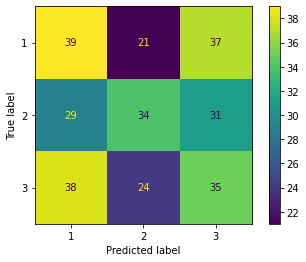

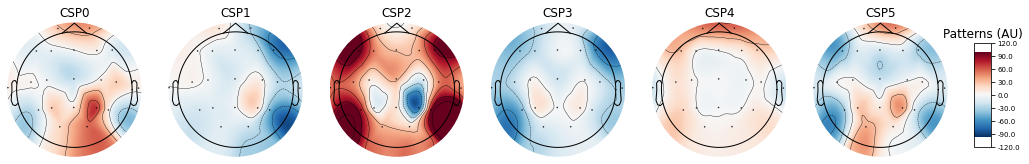

In [6]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=6,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_lda_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_lda_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_lda_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del lda
del csp_lda_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp

In [7]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Unseen trial training with unseen trial testing | CSP + LDA | three class MI task

With poor performance on single trials, we expect the experiment using multiple trials for training and an unseen trial for testing to be even worse.

**Remember the results for subject `C`**

We test different trials as train and test trials:
- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.733
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.622
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.390
  - No predictions for class 3.
- Using index 0 as test and training on index 1:
  - Found accuracy on separate  test trial of: 0.715
- Using index 1 as test and training on index 0:
  - Found accuracy on separate  test trial of: 0.663

**For subject `B` these results are**

We test different trials as train and test trials:
- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.413
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.462
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.474
- Using index 0 as test and training on index 1:
  - Found accuracy on separate  test trial of: 0.427
- Using index 1 as test and training on index 0:
  - Found accuracy on separate  test trial of: 0.386

**For subject `E` the results are**

We test different trials as train and test trials:
- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.376
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.352
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.475
- Using index 0 as test and training on index 1:
  - Found accuracy on separate  test trial of: 0.413
- Using index 1 as test and training on index 0:
  - Found accuracy on separate  test trial of: 0.379

We indeed see poor performance and once again the neutral class seems to be the hardest to predict.
These results are simply too bad to be usefull in any scenario.

In [8]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels_train = []

# Choose a test trial, e.g. first trial
test_trial = mne_raws[0]
test_trial.load_data()

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                   picks="all",
                                   phase="minimum",
                                   fir_window="blackman",
                                   fir_design="firwin",
                                   pad='median', 
                                   n_jobs=-1,
                                   verbose= False)
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded and filtered test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        print(f"Loaded and filtered train epochs")
        
        # Labels: should be integers!
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print(f"Extracted labels from train epochs")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated the train epochs")
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nCreated the test epochs")
print(f"Total amount of train labels: {len(labels_test)}")

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw

Reading 0 ... 729399  =      0.000 ...  3646.995 secs...


Loaded raw data
Loaded and filtered test epochs and extracted labels


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Concatenated the train epochs
Total amount of train labels: 1919


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_6092/3750677225.py:47: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_6092/3750677225.py:52: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)




Created the test epochs
Total amount of train labels: 959


Found accuracy on separate  test trial of: 0.4129301355578728


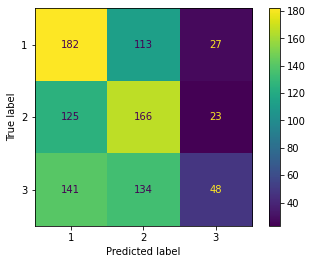

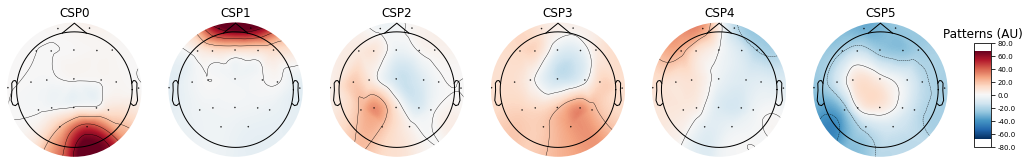

In [9]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data_train = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_data_test = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

    # Configure CSP
    csp = CSP(
        n_components=6,
        reg="oas",
        cov_est="epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configre LDA
    lda = LinearDiscriminantAnalysis(
        solver= "svd"
    )

    # Use scikit-learn Pipeline to connect CSP and LDA
    csp_lda_pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline on the train trial(s)
    csp_lda_pipeline.fit(mne_fixed_window_epochs_data_train, labels_train)
    
    # Test on the test trial
    labels_test_predict = csp_lda_pipeline.predict(mne_fixed_window_epochs_data_test)
    accuracy =  accuracy_score(labels_test, labels_test_predict)
    
# Print single trial result
print(f"Found accuracy on separate  test trial of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= labels_test, y_pred= labels_test_predict)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data_train, labels_train)
 
csp.plot_patterns(mne_fixed_window_epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del accuracy
del csp
del csp_lda_pipeline
del labels_test_predict
del lda
del mne_fixed_window_epochs_data_train
del mne_fixed_window_epochs_data_test


In [10]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs_test
del mne_fixed_window_epochs_train
del labels_test
del labels_train

<hr><hr>

## Band-pass filter to CSP to SVM pipeline

When looking at papers using CSP, for example, the [numerous BCI competition made papers](https://www.bbci.de/competition/iv/results/index.html), a pipeline often looks like this:

1. Passband filtering per subject
2. Multiclass CSP
3. Multiclass SVM

This is very similar to our previous pipeline with only the used classifier being different.
Because of this, we will now use a pipeline with an SVM classifier.
It is noted that SVM does need hyperparameter tuning to be optimal.
We did this hyperparameter tuning through a cross fold validated grid search using the specified parameters.
We only did the hyperparameter tuning for the first index and reused the found configuration for all indexes.
Redoing the optimisations could likely improve the results further.

<hr>

### Fixed window classification: Single trial | CSP + SVM | three class MI task

**The result from the previous notebook performed on subject `C` were:**

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|------------------------------------------|------------------------------------|
| 0              | 0.867 +- 0.012                           | 0.885                              | 0.892 +- 0.010                           | 0.896                              |
| 1              | 0.788 +- 0.043                           | 0.757                              | 0.849 +- 0.012                           | 0.847                              |
| 2              | 0.712 +- 0.014                           | 0.590                              | 0.735 +- 0.016 / 0.751 +- 0.006          | 0.719 / 0.719                      |

**The results from this notebook performed on subject `B` are:**

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|-------------------------|--------|
| 0              | 0.406 +- 0.048                           | 0.375                              | 0.422 +- 0.022          | 0.465  |
| 1              | 0.561 +- 0.021                           | 0.545                              | 0.521 +- 0.022          | 0.560  |
| 2              | 0.683 +- 0.019                           | 0.631                              | 0.683 +- 0.024          | 0.653  |

**The results from this notebook performed on subject `E` are:**

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|-------------------------|--------|
| 0              | 0.673 +- 0.031                           | 0.705                              | 0.671 +- 0.020          | 0.701  |
| 1              | 0.544 +- 0.029                           | 0.517                              | 0.586 +- 0.030          | 0.580  |
| 2              | 0.739 +- 0.025                           | 0.760                              | 0.758 +- 0.011          | 0.805  |



Whilst we do see some improvements, the accuracy still remains far too low to be usable.

In [11]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")

# Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                               picks="all",
                               phase="minimum",
                               fir_window="blackman",
                               fir_design="firwin",
                               pad='median', 
                               n_jobs=-1,
                               verbose= False)
print(f"Got the band-pass filtered epochs: \n")
display(mne_fixed_window_epochs)

# Labels: should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Using data from preloaded Raw for 959 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:

Got the band-pass filtered epochs: 



Number of events,959
Events,task/left: 322task/neutral: 323task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]


Performed cross fold validation and got an average classification score of 0.4222222222222222 with a standard deviation of 0.02202604378771348
Fitted pipeline a single time and got a classification accuracy of 0.4652777777777778


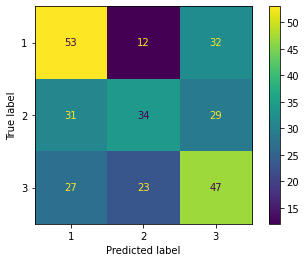

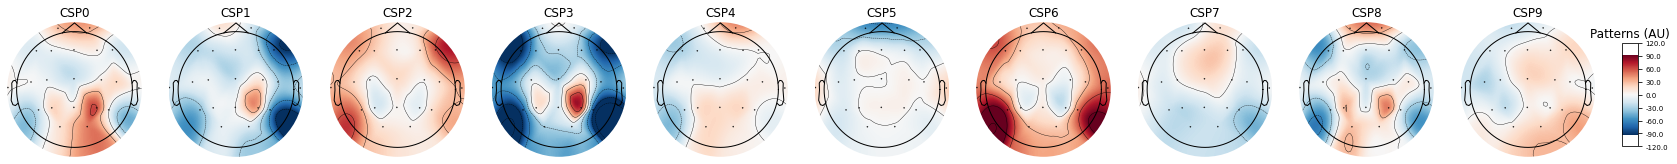

In [12]:
####################################################
# FIXED WINDOW: CSP + SVM
####################################################

# Best found parameters from grid search of previous notebook
best_CSP__n_components = 10
best_CSP__reg = "empirical"
best_CSP__cov_est = "epoch"
best_SVM__C = 1
best_SVM__kernel = "rbf"
best_SVM__gamma = "scale"


with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=best_CSP__n_components,
        reg= best_CSP__reg,
        cov_est= best_CSP__cov_est,
        norm_trace=False,
        component_order="mutual_info")

    # Configre SVM
    svm = SVC(
        C= best_SVM__C,
        kernel= best_SVM__kernel,
        gamma= best_SVM__gamma
    )

    # Use scikit-learn Pipeline to connect CSP and SVM
    csp_svm_pipeline = Pipeline([('CSP', csp), ('SVM', svm)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_svm_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv=cv, 
                             n_jobs=-1,
                             verbose= False,
                             error_score='raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify=labels,                                                    
                                                        random_state=98)
    
    # Fit the pipeline
    csp_svm_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_svm_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del svm
del csp_svm_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp
del best_CSP__n_components
del best_CSP__reg
del best_CSP__cov_est
del best_SVM__C
del best_SVM__kernel
del best_SVM__gamma

In [13]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Unseen trial training with unseen trial testing | CSP + SVM | three class MI task

With better but still poor performance on single trials, we expect the experiment using multiple trials for training and an unseen trial for testing to still be unusable.

**Remember the results for subject `C`**

- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.782 (lda: 0.733)
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.635 (lda: 0.622)
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.347 (lda: 0.390)
  - Never predicts 3 -> `task/neutral`

**For subject `B` these results are**

- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.409 (lda: 0.413)
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.497 (lda: 0.462)
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.502 (lda: 0.474)

**For subject `E` the results are**

- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.398 (lda: 0.376)
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.371 (lda: 0.352)
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.475 (lda: 0.475)

SVM seems to perform better then LDA, but the found performance is still far less then desired.

In [14]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels_train = []

# Choose a test trial, e.g. first trial
test_trial = mne_raws[0]
test_trial.load_data()

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded and filtered test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        print(f"Loaded and filtered train epochs")
        
        # Labels: should be integers!
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print(f"Extracted labels from train epochs")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated the train epochs")
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nGot the test epochs")
print(f"Total amount of train labels: {len(labels_test)}")

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw



Loaded raw data
Loaded and filtered test epochs and extracted labels


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Concatenated the train epochs
Total amount of train labels: 1919


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_6092/3878767206.py:47: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_6092/3878767206.py:52: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)




Got the test epochs
Total amount of train labels: 959


Found accuracy on separate  test trial of: 0.40875912408759124


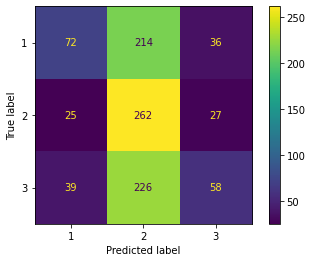

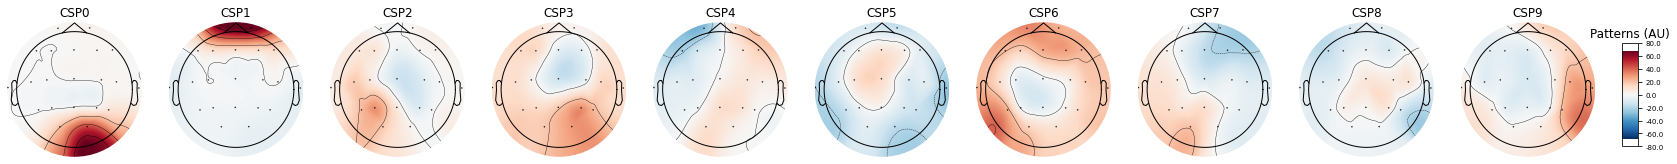

In [15]:
####################################################
# FIXED WINDOW: CSP + SVM
####################################################

# Specify the best found parameters
best_CSP__n_components = 10
best_CSP__reg = "empirical"
best_CSP__cov_est = "epoch"
best_SVM__C = 1
best_SVM__kernel = "rbf"
best_SVM__gamma = "scale"

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data_train = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_data_test = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

    # Configure CSP
    csp = CSP(
        n_components=best_CSP__n_components,
        reg= best_CSP__reg,
        cov_est= best_CSP__cov_est,
        norm_trace=False,
        component_order="mutual_info")

    # Configre SVMConfigre SVM
    svm = SVC(
        C= best_SVM__C,
        kernel= best_SVM__kernel,
        gamma= best_SVM__gamma
    )

    # Use scikit-learn Pipeline to connect CSP and SVM
    csp_svm_pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline on the train trial(s)
    csp_svm_pipeline.fit(mne_fixed_window_epochs_data_train, labels_train)
    
    # Test on the test trial
    labels_test_predict = csp_svm_pipeline.predict(mne_fixed_window_epochs_data_test)
    accuracy =  accuracy_score(labels_test, labels_test_predict)
    
# Print single trial result
print(f"Found accuracy on separate  test trial of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= labels_test, y_pred= labels_test_predict)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data_train, labels_train)
 
csp.plot_patterns(mne_fixed_window_epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del accuracy
del csp
del csp_svm_pipeline
del labels_test_predict
del svm
del mne_fixed_window_epochs_data_train
del mne_fixed_window_epochs_data_test
del best_CSP__n_components
del best_CSP__reg
del best_CSP__cov_est
del best_SVM__C
del best_SVM__kernel
del best_SVM__gamma


In [16]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs_test
del mne_fixed_window_epochs_train
del labels_test
del labels_train

<hr><hr>

## Band-pass filter to CSP to MLP pipeline

MLP is a more complex model then SVM and performed the best on subject `C` in the previous notebook.
We can see if the added complexity from an MLP classifier can improve the results on these subjects to usefull levels.

<hr>

### Fixed window classification: Single trial | CSP + MLP | three class MI task


**The result from the previous notebook performed on subject `C` were:**

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: train/test accuracy** | **CSP + MLP: cross validation accuracy** | **CSP + MLP: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|------------------------------------------|------------------------------------|------------------------------------------|------------------------------------|
| 0              | 0.867 +- 0.012                           | 0.885                              | 0.892 +- 0.010                           | 0.896                              | 0.898 +- 0.012                            | 0.892                              |
| 1              | 0.788 +- 0.043                           | 0.757                              | 0.849 +- 0.012                           | 0.847                              | 0.852 +- 0.014                           | 0.837                              |
| 2              | 0.712 +- 0.014                           | 0.590                              | 0.751 +- 0.006                           | 0.719                              | 0.746 +- 0.015                           | 0.726                              |

**The results from this notebook performed on subject `B` are:**

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: train/test accuracy** | **CSP + MLP: cross validation accuracy** | **CSP + MLP: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|------------------------------------------|------------------------------------|------------------------------------------|------------------------------------|
| 0              | 0.406 +- 0.048                           | 0.375                              | 0.422 +- 0.022                           | 0.465                              | 0.411 +- 0.021                            | 0.458                              |
| 1              | 0.561 +- 0.021                           | 0.545                              | 0.521 +- 0.022                           | 0.560                              | 0.513 +- 0.035                           | 0.556                              |
| 2              | 0.683 +- 0.019                           | 0.631                              | 0.683 +- 0.024                           | 0.653                              | 0.642 +- 0.042                           | 0.646                              |

**The results from this notebook performed on subject `E` are:**

| **File index** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: train/test accuracy** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: train/test accuracy** | **CSP + MLP: cross validation accuracy** | **CSP + MLP: train/test accuracy** |
|----------------|------------------------------------------|------------------------------------|------------------------------------------|------------------------------------|------------------------------------------|------------------------------------|
| 0              | 0.673 +- 0.031                           | 0.705                              | 0.671 +- 0.020                           | 0.701                              | 0.602 +- 0.036                           | 0.569                              |
| 1              | 0.544 +- 0.029                           | 0.517                              | 0.586 +- 0.030                           | 0.580                              | 0.517 +- 0.021                           | 0.496                              |
| 2              | 0.739 +- 0.025                           | 0.760                              | 0.758 +- 0.011                           | 0.805                              | 0.714 +- 0.028                           | 0.718                              |


We see that SVM actually outperformed MLP for these two extra subjects.
MLP could probably benefit from patient per patient optimisation more then the rather general parameter settings for SVM used.










In [17]:
####################################################
# PREPPING THE DATA
####################################################

# Get the epoch from the RAW limited to MI tasks
# Include period before and after to enable filtering possibilities
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']

# Load the epochs
mne_fixed_window_epochs.load_data()
print(f"Loaded fixed window binary epochs:\n")

# Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                               picks="all",
                               phase="minimum",
                               fir_window="blackman",
                               fir_design="firwin",
                               pad='median', 
                               n_jobs=-1,
                               verbose= False)
print(f"Got the band-pass filtered epochs: \n")
display(mne_fixed_window_epochs)

# Labels: should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Using data from preloaded Raw for 959 events and 801 original time points ...
0 bad epochs dropped
Loaded fixed window binary epochs:

Got the band-pass filtered epochs: 



Number of events,959
Events,task/left: 322task/neutral: 323task/right: 314
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]


Performed cross fold validation and got an average classification score of 0.3979166666666667 with a standard deviation of 0.015774745405000762
Fitted pipeline a single time and got a classification accuracy of 0.4548611111111111


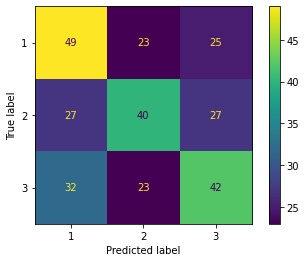

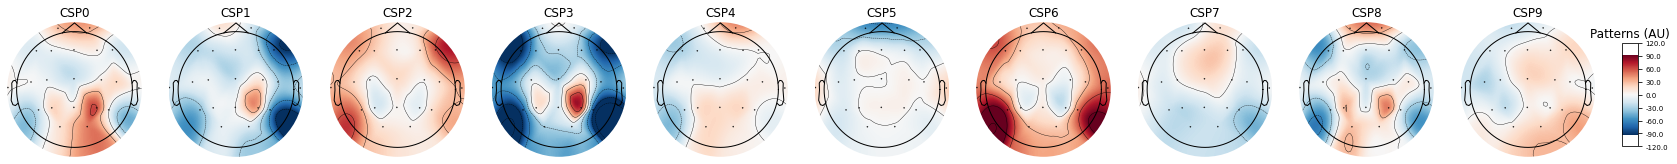

In [18]:
####################################################
# FIXED WINDOW: CSP + MLP
####################################################

# Specify the best found parameters
## Best found params for index 1 file: {'CSP__n_components': 3, 'MLP__activation': 'relu', 'MLP__alpha': 0.001, 'MLP__hidden_layer_sizes': (50,), 'MLP__max_iter': 200, 'MLP__solver': 'adam'}
best_CSP__n_components = 10

best_MLP__activation = 'tanh'
best_MLP__alpha = 0.001
best_MLP__hidden_layer_sizes = (100)
best_MLP__max_iter= 10000
best_MLP__solver = 'adam'


with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data = mne_fixed_window_epochs.get_data(tmin=0.2, tmax=0.7)

    # Use cross validation but keeping a reasonable amount of epochs per fold
    cv = ShuffleSplit(n_splits=5,
                      test_size=0.3,
                      random_state=98)

    # Configure CSP
    csp = CSP(
        n_components=best_CSP__n_components,
        reg= "empirical",
        cov_est= "epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configure MLP
    mlp = MLPClassifier(
        shuffle= True,
        warm_start= False,
        activation= best_MLP__activation,
        alpha= best_MLP__alpha,
        hidden_layer_sizes= best_MLP__hidden_layer_sizes,
        max_iter= best_MLP__max_iter,
        solver= best_MLP__solver
    )

    # Use scikit-learn Pipeline to connect CSP and MLP with "fixed" parameters
    csp_mlp_pipeline = Pipeline([('CSP', csp), ('MLP', mlp)])

    # Get score from cross validation
    scores = cross_val_score(estimator= csp_mlp_pipeline, 
                             X= mne_fixed_window_epochs_data, 
                             y= labels, 
                             cv= cv, 
                             n_jobs= -1,
                             verbose= False,
                             error_score= 'raise')
    
# Print CV results
print(f"Performed cross fold validation and got an average classification score of {scores.mean()} with a standard deviation of {scores.std()}")

# Get score from cross validation
with io.capture_output():
    # Train on a singular split
    X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, 
                                                        test_size = 0.3,
                                                        shuffle= True,
                                                        stratify= labels,                                                    
                                                        random_state= 98)
    
    # Fit the pipeline
    csp_mlp_pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = csp_mlp_pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
# Print single trial result
print(f"Fitted pipeline a single time and got a classification accuracy of {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()
    
# plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data, labels)
 
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del cv
del mlp
del csp_mlp_pipeline
del X_train
del X_test
del y_train
del mne_fixed_window_epochs_data
del accuracy
del scores
del y_test
del y_pred
del csp
del best_CSP__n_components
del best_MLP__activation
del best_MLP__alpha
del best_MLP__hidden_layer_sizes
del best_MLP__max_iter
del best_MLP__solver

In [19]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs
del labels

<hr>

### Fixed window classification: Unseen trial training with unseen trial testing | CSP + MLP | three class MI task

**Remember the results for subject `C`**

- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.785 (lda: 0.733 | SVM: 0.782)
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.657 (lda: 0.622 | SVM: 0.635)
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.365 (lda: 0.390 | SVM: 0.347)
  - Just like before, predicting `task/neutral` almost never happens, although it did guess 2/3 correct now (so a total of 3 "class 3" predictions).

**For subject `B` these results are**

- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.420 (lda: 0.413 | SVM: 0.409)
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.495 (lda: 0.462 | SVM: 0.497)
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.475 (lda: 0.474 | SVM: 0.502)

**For subject `E` the results are**

- Using index 0 as test and others as train:
  - Found accuracy on separate  test trial of: 0.388 (lda: 0.376 | SVM: 0.398)
- Using index 1 as test and others as train:
  - Found accuracy on separate  test trial of: 0.445 (lda: 0.352 | SVM: 0.371)
- Using index 2 as test and others as train:
  - Found accuracy on separate  test trial of: 0.454 (lda: 0.475 | SVM: 0.475)

In [20]:
####################################################
# PREPPING THE DATA
####################################################

# Init variables
epochs = []
labels_train = []

# Choose a test trial, e.g. first trial
test_trial = mne_raws[0]
test_trial.load_data()

for single_mne_raw in mne_raws:
    # Load data of raw
    with io.capture_output():
        single_mne_raw.load_data()
    print(f"\n\nLoaded raw data")
    
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    with io.capture_output():
        mne_fixed_window_epochs.load_data()
    
    # Overlap-add FIR filter to include 2-32 Hz signals, broader for generality
    mne_fixed_window_epochs.filter(l_freq = 2, h_freq=32,
                                picks="all",
                                phase="minimum",
                                fir_window="blackman",
                                fir_design="firwin",
                                pad='median', 
                                n_jobs=-1,
                                verbose= False)
    
    if (single_mne_raw == test_trial):
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        labels_test = mne_fixed_window_epochs.events[:, -1]
        print("Loaded and filtered test epochs and extracted labels")
    else:  
        epochs.append(mne_fixed_window_epochs)
        print(f"Loaded and filtered train epochs")
        
        # Labels: should be integers!
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print(f"Extracted labels from train epochs")
    
# Make single epoch object for training
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated the train epochs")
print(f"Total amount of train labels: {len(labels_train)}")
    
# Show test epoch object
mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nGot the test epochs")
print(f"Total amount of train labels: {len(labels_test)}")

# Remove unused variables
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw



Loaded raw data
Loaded and filtered test epochs and extracted labels


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Loaded raw data
Loaded and filtered train epochs
Extracted labels from train epochs


Concatenated the train epochs
Total amount of train labels: 1919


/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_6092/3878767206.py:47: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
/var/folders/2w/l6d4c6ys1fg0ky5s_p_ts1_m0000gn/T/ipykernel_6092/3878767206.py:52: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)




Got the test epochs
Total amount of train labels: 959


Found accuracy on separate  test trial of: 0.40771637122002086


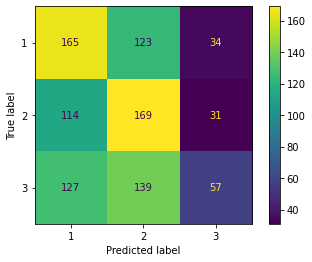

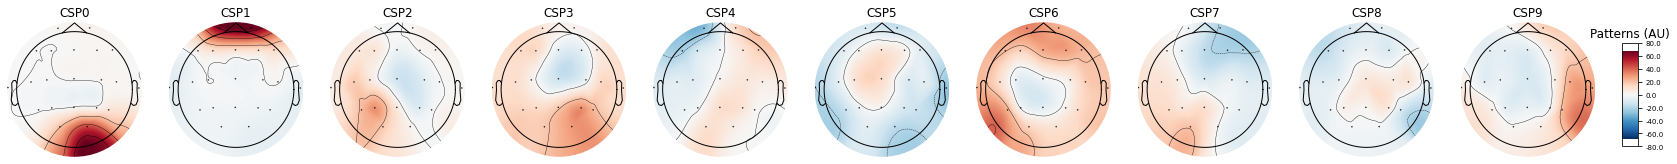

In [21]:
####################################################
# FIXED WINDOW: CSP + MLP
####################################################

# Specify the best found parameters
best_CSP__n_components = 10

best_MLP__activation = 'tanh'
best_MLP__alpha = 0.001
best_MLP__hidden_layer_sizes = (100)
best_MLP__max_iter= 100
best_MLP__solver = 'adam'

with io.capture_output():
    # Get data of epochs, limited to half half a second
    mne_fixed_window_epochs_data_train = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_data_test = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)

    # Configure CSP
    csp = CSP(
        n_components=best_CSP__n_components,
        reg= "empirical",
        cov_est= "epoch",
        norm_trace=False,
        component_order="mutual_info")

    # Configure MLP
    mlp = MLPClassifier(
        shuffle= True,
        warm_start= False,
        activation= best_MLP__activation,
        alpha= best_MLP__alpha,
        hidden_layer_sizes= best_MLP__hidden_layer_sizes,
        max_iter= best_MLP__max_iter,
        solver= best_MLP__solver
    )

    # Use scikit-learn Pipeline to connect CSP and MLP with "fixed" parameters
    csp_mlp_pipeline = Pipeline([('CSP', csp), ('MLP', mlp)])
    
    # Fit the pipeline on the train trial(s)
    csp_mlp_pipeline.fit(mne_fixed_window_epochs_data_train, labels_train)
    
    # Test on the test trial
    labels_test_predict = csp_mlp_pipeline.predict(mne_fixed_window_epochs_data_test)
    accuracy =  accuracy_score(labels_test, labels_test_predict)
    
# Print single trial result
print(f"Found accuracy on separate  test trial of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= labels_test, y_pred= labels_test_predict)
plt.show()
    
# Plot CSP patterns estimated on full data for visualization
with io.capture_output():
    csp.fit_transform(mne_fixed_window_epochs_data_train, labels_train)
 
csp.plot_patterns(mne_fixed_window_epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
plt.show()

# Remove unsused variables
del accuracy
del csp
del csp_mlp_pipeline
del labels_test_predict
del mlp
del mne_fixed_window_epochs_data_train
del mne_fixed_window_epochs_data_test
del best_CSP__n_components
del best_MLP__activation
del best_MLP__alpha
del best_MLP__hidden_layer_sizes
del best_MLP__max_iter
del best_MLP__solver


In [22]:
####################################################
# CLEAN REMAINING VARIABLES
####################################################

# Remove unused variables
del mne_fixed_window_epochs_test
del mne_fixed_window_epochs_train
del labels_test
del labels_train

## End of notebook

In [23]:
# Delete unused variables
del mne_raw
del mne_raws
del subject